In [1]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Torch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA RTX A5000


In [ ]:
import pandas as pd
from pathlib import Path

PROC = Path("G:/My Drive/eye_project/processed/splits_strict_10cls_new")

def load_split(csv_file):
    df = pd.read_csv(csv_file)
   
    df['img_path'] = df['img_path'].str.replace(
        "/content/drive/MyDrive/eye_project",
        "G:/My Drive/eye_project"
    )
    return df

train_df = load_split(PROC / "train.csv")
val_df   = load_split(PROC / "val.csv")
test_df  = load_split(PROC / "test.csv")

print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)
print("Test shape:", test_df.shape)
print(train_df.head())


Train shape: (768, 15)
Val shape: (165, 15)
Test shape: (165, 15)
                 UID    ID        source label  AION  ARMD  BRVO  CRVO  DR  \
0   rfmid1_train_317   317  rfmid1_train    DN     0     0     0     0   0   
1   rfmid2_train_625   625  rfmid2_train    DR     0     0     0     0   1   
2     rfmid1_test_16    16           NaN   ERM     0     0     0     0   0   
3    rfmid1_test_335   335           NaN    DR     0     0     0     0   1   
4  rfmid1_train_1065  1065  rfmid1_train    DR     0     0     0     0   1   

   MHL  ERM  ODC  RPEC  DN                                           img_path  
0    0    0    0     0   1  G:/My Drive/eye_project/raw/RFMiD/Training_Set...  
1    0    0    0     0   0  G:/My Drive/eye_project/raw/RFMiD2_0/train/625...  
2    0    1    0     0   0  G:/My Drive/eye_project/raw/RFMiD/Test_Set/Tes...  
3    0    0    0     0   0  G:/My Drive/eye_project/raw/RFMiD/Test_Set/Tes...  
4    0    0    0     0   0  G:/My Drive/eye_project/raw/RFMiD/Tra

In [ ]:
from PIL import Image

test_path = train_df.iloc[0]["img_path"]
print("Testing image:", test_path)

img = Image.open(test_path).convert("RGB")
print("Image size:", img.size, "Mode:", img.mode)
img.show() 

Testing image: G:/My Drive/eye_project/raw/RFMiD/Training_Set/Training/317.png
Image size: (2144, 1424) Mode: RGB


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = len(CLASSES)

# ---- Model (ResNet34) ----
model = timm.create_model("resnet34", pretrained=True, num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# ---- Loss & Optimizer ----
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

print("Model ready on:", DEVICE)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Model ready on: cuda


c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\admin\.cache\huggingface\hub\models--timm--resnet34.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
import os, shutil
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# --- 1) Configure source (Drive) and destination (local SSD) ---
SRC_ROOT = Path(r"G:\My Drive\eye_project")          
DST_ROOT = Path(r"C:\datasets\eye_project")         

SRC_RAW  = SRC_ROOT / "raw"
SRC_PROC = SRC_ROOT / "processed"
DST_RAW  = DST_ROOT / "raw"
DST_PROC = DST_ROOT / "processed"

for p in [DST_ROOT, DST_RAW, DST_PROC, DST_PROC / "splits_strict_10cls_new"]:
    p.mkdir(parents=True, exist_ok=True)

# --- 2) Load splits from Drive ---
SPLITS_DRIVE = SRC_PROC / "splits_strict_10cls_new"
train_df = pd.read_csv(SPLITS_DRIVE / "train.csv")
val_df   = pd.read_csv(SPLITS_DRIVE / "val.csv")
test_df  = pd.read_csv(SPLITS_DRIVE / "test.csv")


def to_drive_prefix(p: str) -> str:
    return str(p).replace("/content/drive/MyDrive/eye_project", str(SRC_ROOT))

for df in (train_df, val_df, test_df):
    df["img_path"] = df["img_path"].astype(str).apply(to_drive_prefix)

# --- 3) Collect all unique image paths to copy ---
all_paths = pd.concat([train_df["img_path"], val_df["img_path"], test_df["img_path"]]).unique().tolist()

all_paths = [p for p in all_paths if Path(p).exists()]
print(f"Total images to copy: {len(all_paths):,}")

# --- 4) Copy images preserving relative structure under 'raw/' ---
def rel_under_raw(full_path: Path) -> Path:
 
    return full_path.relative_to(SRC_RAW)

copied, skipped = 0, 0
for src_str in tqdm(all_paths, desc="Copying images"):
    src = Path(src_str)
    try:
        rel = rel_under_raw(src)                  # e.g., RFMiD/Training_Set/Training/317.png
    except Exception:
        # If the image isn't under SRC_RAW, try to infer the subpath after 'raw\'
        # e.g., G:\My Drive\eye_project\raw\RFMiD\... → take part after '\raw\'
        parts = src.parts
        if "raw" in parts:
            idx = parts.index("raw")
            rel = Path(*parts[idx+1:])
        else:
            # last resort: flatten into one folder
            rel = Path(src.name)
    dst = DST_RAW / rel
    dst.parent.mkdir(parents=True, exist_ok=True)
    if not dst.exists():
        shutil.copy2(src, dst)
        copied += 1
    else:
        skipped += 1

print(f"Images copied: {copied:,}  (already existed: {skipped:,})")

# --- 5) Copy processed CSVs (merged + split summary) ---

for name in ["merged_strict_10cls.csv", "split_class_summary.csv"]:
    src_file = (SRC_PROC / name) if name.endswith(".csv") and (SRC_PROC / name).exists() else (SPLITS_DRIVE / name)
    if src_file.exists():
        dst_file = (DST_PROC / src_file.name) if src_file.parent == SRC_PROC else (DST_PROC / "splits_strict_10cls_new" / src_file.name)
        shutil.copy2(src_file, dst_file)

# --- 6) Write NEW splits with local paths (C:\datasets\...) ---
def to_local_prefix(p: str) -> str:
    return str(p).replace(str(SRC_ROOT), str(DST_ROOT))

def write_local(df: pd.DataFrame, fname: str):
    out = df.copy()
    out["img_path"] = out["img_path"].astype(str).apply(to_local_prefix)
    out.to_csv(DST_PROC / "splits_strict_10cls_new" / fname, index=False)

write_local(train_df, "train_local.csv")
write_local(val_df,   "val_local.csv")
write_local(test_df,  "test_local.csv")

print("\n✅ Done.")
print("Local splits saved to:", DST_PROC / "splits_strict_10cls_new")
print("Use these in your notebook:")
print(rf'  TRAIN_CSV = r"{DST_PROC}\splits_strict_10cls_new\train_local.csv"')
print(rf'  VAL_CSV   = r"{DST_PROC}\splits_strict_10cls_new\val_local.csv"')
print(rf'  TEST_CSV  = r"{DST_PROC}\splits_strict_10cls_new\test_local.csv"')


Total images to copy: 1,098


Copying images: 100%|██████████| 1098/1098 [10:30<00:00,  1.74it/s]


Images copied: 1,098  (already existed: 0)

✅ Done.
Local splits saved to: C:\datasets\eye_project\processed\splits_strict_10cls_new
Use these in your notebook:
  TRAIN_CSV = r"C:\datasets\eye_project\processed\splits_strict_10cls_new\train_local.csv"
  VAL_CSV   = r"C:\datasets\eye_project\processed\splits_strict_10cls_new\val_local.csv"
  TEST_CSV  = r"C:\datasets\eye_project\processed\splits_strict_10cls_new\test_local.csv"


# ==== Cell 1: Setup & Load local CSVs (after image-copy step) ====

In [ ]:
import os, json, time
from pathlib import Path
import pandas as pd
import numpy as np
import torch

# --- Paths: local SSD copies created earlier ---
ROOT_LOCAL = Path(r"C:\datasets\eye_project")
PROC_LOCAL = ROOT_LOCAL / "processed" / "splits_strict_10cls_new"

TRAIN_CSV = PROC_LOCAL / "train_local.csv"
VAL_CSV   = PROC_LOCAL / "val_local.csv"
TEST_CSV  = PROC_LOCAL / "test_local.csv"

# --- Classes (single-label, fixed order) ---
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASSES)}
NUM_CLASSES  = len(CLASSES)

# --- Reproducibility & device ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# --- Load splits (local) ---
assert TRAIN_CSV.exists() and VAL_CSV.exists() and TEST_CSV.exists(), "Local split CSVs not found."
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Train/Val/Test shapes:", train_df.shape, val_df.shape, test_df.shape)
print("Columns:", list(train_df.columns))
train_df.head(3)


Device: cuda
Train/Val/Test shapes: (768, 15) (165, 15) (165, 15)
Columns: ['UID', 'ID', 'source', 'label', 'AION', 'ARMD', 'BRVO', 'CRVO', 'DR', 'MHL', 'ERM', 'ODC', 'RPEC', 'DN', 'img_path']


,UID,ID,source,label,AION,ARMD,BRVO,CRVO,DR,MHL,ERM,ODC,RPEC,DN,img_path
0,rfmid1_train_317,317,rfmid1_train,DN,0,0,0,0,0,0,0,0,0,1,C:\datasets\eye_project/raw/RFMiD/Training_Set...
1,rfmid2_train_625,625,rfmid2_train,DR,0,0,0,0,1,0,0,0,0,0,C:\datasets\eye_project/raw/RFMiD2_0/train/625...
2,rfmid1_test_16,16,NaN,ERM,0,0,0,0,0,0,1,0,0,0,C:\datasets\eye_project/raw/RFMiD/Test_Set/Tes...


# ==== Cell 2: Transforms, Dataset, DataLoaders (no aug) ====

In [ ]:
from torch.utils.data import Dataset, DataLoader, default_collate
from torchvision import transforms
from PIL import Image
import torch

# 1) Transform: Resize -> ToTensor -> Normalize (ImageNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet mean
        std=[0.229, 0.224, 0.225]     # ImageNet std
    )
])

# 2) Dataset (single-label)
class FundusDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        
        self.img_col = "img_path"
        assert self.img_col in self.df.columns, f"'{self.img_col}' not found in columns: {list(self.df.columns)}"
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row[self.img_col]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_idx = CLASS_TO_IDX[row["label"]]
        return img, torch.tensor(label_idx, dtype=torch.long)

# 3) Collate that skips any None (safety)
def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    return default_collate(batch) if len(batch) else (torch.empty(0), torch.empty(0, dtype=torch.long))

# 4) Build loaders (Windows-safe: num_workers=0)
BATCH_SIZE = 32
PIN_MEMORY = torch.cuda.is_available()

train_ds = FundusDataset(train_df, transform)
val_ds   = FundusDataset(val_df,   transform)
test_ds  = FundusDataset(test_df,  transform)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=0, pin_memory=PIN_MEMORY, collate_fn=safe_collate)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=0, pin_memory=PIN_MEMORY, collate_fn=safe_collate)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=0, pin_memory=PIN_MEMORY, collate_fn=safe_collate)

# 5) Sanity check: one batch
xb, yb = next(iter(train_dl))
print("Batch images:", tuple(xb.shape))  # expect (32, 3, 224, 224)
print("Batch labels:", tuple(yb.shape))  # expect (32,)
print("First 10 labels:", yb[:10].tolist())


Batch images: (32, 3, 224, 224)
Batch labels: (32,)
First 10 labels: [7, 2, 4, 4, 7, 2, 4, 1, 4, 4]


# ==== Cell 3: ResNet34 model, optimizer, 50-epoch training (no early stopping) ====

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import time
from pathlib import Path
import json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = len(CLASSES)

# 1) Model: ResNet34 (pretrained on ImageNet), 10-class head
model = timm.create_model("resnet34", pretrained=True, num_classes=NUM_CLASSES).to(DEVICE)

# 2) Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# 3) Training helpers
def run_epoch(model, dl, optimizer, criterion, device, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    if train:
        for xb, yb in dl:
            if xb.nelement() == 0:
                continue
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(1)
            total_correct += (preds == yb).sum().item()
            total_samples += xb.size(0)
    else:
        with torch.no_grad():
            for xb, yb in dl:
                if xb.nelement() == 0:
                    continue
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                total_loss += loss.item() * xb.size(0)
                preds = out.argmax(1)
                total_correct += (preds == yb).sum().item()
                total_samples += xb.size(0)

    avg_loss = total_loss / max(1, total_samples)
    avg_acc  = total_correct / max(1, total_samples)
    return avg_loss, avg_acc

# 4) Train for 50 epochs and save best (by Val Acc)
EPOCHS = 50
MODEL_DIR = Path(r"C:\datasets\eye_project\models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "epoch_time_sec": []}

t0 = time.time()
for epoch in range(1, EPOCHS + 1):
    ep_start = time.time()

    tr_loss, tr_acc = run_epoch(model, train_dl, optimizer, criterion, DEVICE, train=True)
    val_loss, val_acc = run_epoch(model, val_dl, optimizer, criterion, DEVICE, train=False)

    ep_time = time.time() - ep_start
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["epoch_time_sec"].append(ep_time)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"Epoch time: {ep_time:.1f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_DIR / "resnet34_best.pth")

t_total = time.time() - t0
print(f"\nTraining finished in {t_total/60:.2f} min")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# 5) Save history for plotting later
with open(MODEL_DIR / "resnet34_history.json", "w") as f:
    json.dump(history, f, indent=2)

print(f"Saved best model  → {MODEL_DIR / 'resnet34_best.pth'}")
print(f"Saved train log   → {MODEL_DIR / 'resnet34_history.json'}")


Epoch 01/50 | Train Loss: 2.1358, Train Acc: 0.3268 | Val Loss: 2.0396, Val Acc: 0.5333 | Epoch time: 101.7s
Epoch 02/50 | Train Loss: 1.8010, Train Acc: 0.5000 | Val Loss: 1.7976, Val Acc: 0.4909 | Epoch time: 90.3s
Epoch 03/50 | Train Loss: 1.5606, Train Acc: 0.5130 | Val Loss: 1.5900, Val Acc: 0.4848 | Epoch time: 113.5s
Epoch 04/50 | Train Loss: 1.3892, Train Acc: 0.5612 | Val Loss: 1.5825, Val Acc: 0.5515 | Epoch time: 98.1s
Epoch 05/50 | Train Loss: 1.2591, Train Acc: 0.5951 | Val Loss: 1.4494, Val Acc: 0.5273 | Epoch time: 104.1s
Epoch 06/50 | Train Loss: 1.1528, Train Acc: 0.6250 | Val Loss: 1.4640, Val Acc: 0.5636 | Epoch time: 112.9s
Epoch 07/50 | Train Loss: 1.0340, Train Acc: 0.6576 | Val Loss: 1.3394, Val Acc: 0.5879 | Epoch time: 109.7s
Epoch 08/50 | Train Loss: 0.9462, Train Acc: 0.6745 | Val Loss: 1.2780, Val Acc: 0.5939 | Epoch time: 98.7s
Epoch 09/50 | Train Loss: 0.8515, Train Acc: 0.7214 | Val Loss: 1.2845, Val Acc: 0.5879 | Epoch time: 99.9s
Epoch 10/50 | Train Los

# ==== ResNet34 — Test Evaluation (Confusion Matrix, Report, ROC–AUC, Curves) ====

C:\Users\admin\AppData\Local\Temp\ipykernel_25880\3511096896.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(CKPT_PATH, map_location=DEVICE)


✅ Loaded best ResNet34: C:\datasets\eye_project\models\resnet34_best.pth

✅ Test Accuracy: 0.7091

=== Classification Report (per class) ===
              precision    recall  f1-score   support

        AION     0.0000    0.0000    0.0000         3
        ARMD     0.6000    0.2727    0.3750        11
        BRVO     0.5833    0.4667    0.5185        15
        CRVO     0.8571    0.7500    0.8000         8
          DR     0.8228    0.9155    0.8667        71
         MHL     0.0000    0.0000    0.0000         2
         ERM     0.0000    0.0000    0.0000         2
         ODC     0.6176    0.8077    0.7000        26
        RPEC     0.0000    0.0000    0.0000         3
          DN     0.5556    0.6250    0.5882        24

    accuracy                         0.7091       165
   macro avg     0.4036    0.3838    0.3848       165
weighted avg     0.6668    0.7091    0.6797       165



c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

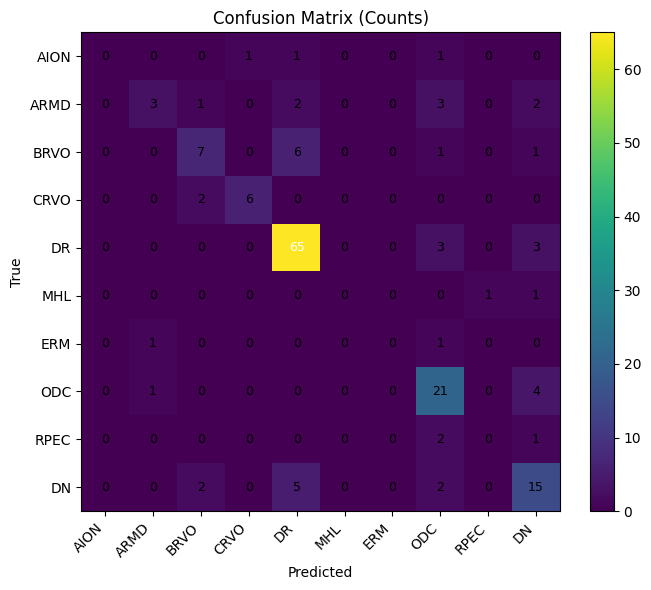


=== ROC–AUC ===
Micro-AUC: 0.9412 | Macro-AUC: 0.8774
AION: 0.9918
ARMD: 0.8489
BRVO: 0.7800
CRVO: 0.9976
DR: 0.9383
MHL: 0.9877
ERM: 0.7331
ODC: 0.9463
RPEC: 0.6564
DN: 0.8939


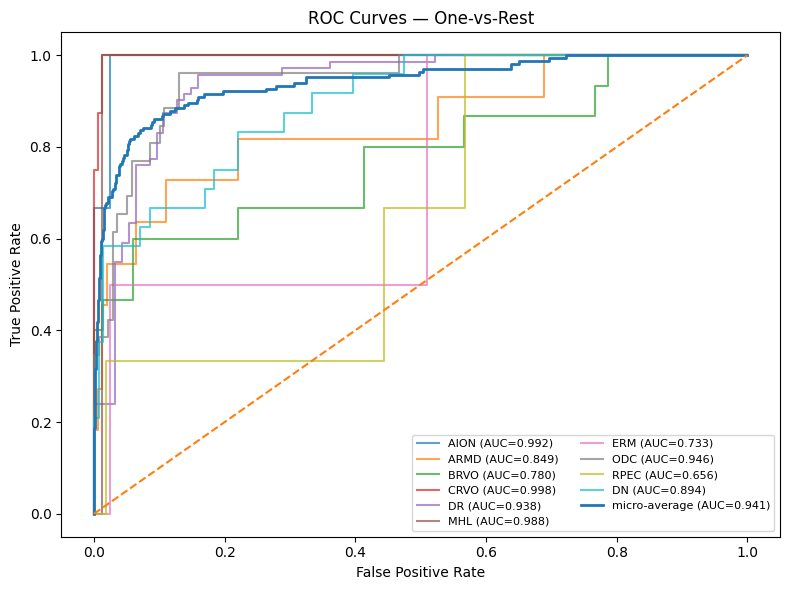

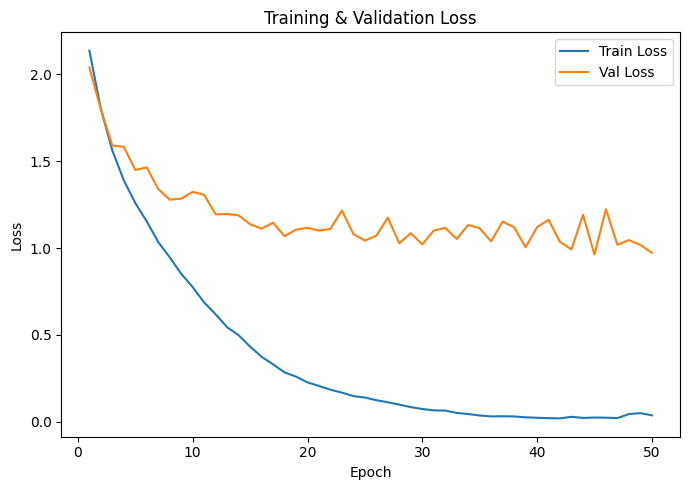

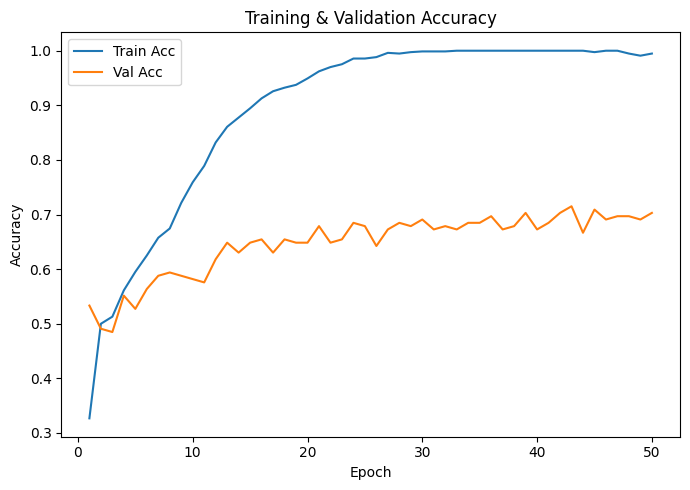

In [ ]:
import torch
import torch.nn.functional as F
import timm
import numpy as np
import json
from pathlib import Path
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_curve, auc
)
import matplotlib.pyplot as plt

# ---- Paths ----
MODEL_DIR = Path(r"C:\datasets\eye_project\models")
CKPT_PATH = MODEL_DIR / "resnet34_best.pth"
HIST_PATH = MODEL_DIR / "resnet34_history.json"

# ---- Rebuild and load best model ----
NUM_CLASSES = len(CLASSES)
model = timm.create_model("resnet34", pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)
state = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()
print("✅ Loaded best ResNet34:", CKPT_PATH)

# ---- Inference on test set ----
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for xb, yb in test_dl:
        if xb.nelement() == 0:
            continue
        xb = xb.to(DEVICE)
        logits = model(xb)
        probs  = F.softmax(logits, dim=1).cpu().numpy()
        preds  = probs.argmax(axis=1)

        y_prob.append(probs)
        y_pred.append(preds)
        y_true.append(yb.numpy())

y_prob = np.concatenate(y_prob, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

# ---- Overall Accuracy ----
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# ---- Classification Report ----
print("\n=== Classification Report (per class) ===")
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

# ---- Confusion Matrix (with counts) ----
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix (Counts)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(np.arange(NUM_CLASSES))
ax.set_yticks(np.arange(NUM_CLASSES))
ax.set_xticklabels(CLASSES, rotation=45, ha="right")
ax.set_yticklabels(CLASSES)

# annotate counts
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        ax.text(j, i, str(cm[i, j]),
                ha="center", va="center",
                fontsize=9, color="white" if cm[i,j] > cm.max()/2 else "black")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# ---- ROC–AUC (one-vs-rest) ----
# Binarize true labels
y_true_ovr = np.zeros((y_true.shape[0], NUM_CLASSES), dtype=int)
y_true_ovr[np.arange(y_true.shape[0]), y_true] = 1

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_ovr[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_ovr.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# macro-average
roc_auc["macro"] = np.mean([roc_auc[i] for i in range(NUM_CLASSES)])

print("\n=== ROC–AUC ===")
print(f"Micro-AUC: {roc_auc['micro']:.4f} | Macro-AUC: {roc_auc['macro']:.4f}")
for i, cls in enumerate(CLASSES):
    print(f"{cls}: {roc_auc[i]:.4f}")

# Plot ROC curves (all classes + micro)
plt.figure(figsize=(8,6))
for i, cls in enumerate(CLASSES):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC={roc_auc[i]:.3f})", alpha=0.7)
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC={roc_auc['micro']:.3f})", linewidth=2)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — One-vs-Rest")
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

# ---- Training curves from history JSON ----
if HIST_PATH.exists():
    with open(HIST_PATH, "r") as f:
        hist = json.load(f)
    epochs = np.arange(1, len(hist["train_loss"])+1)

    # Loss
    plt.figure(figsize=(7,5))
    plt.plot(epochs, hist["train_loss"], label="Train Loss")
    plt.plot(epochs, hist["val_loss"],   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Accuracy
    plt.figure(figsize=(7,5))
    plt.plot(epochs, hist["train_acc"], label="Train Acc")
    plt.plot(epochs, hist["val_acc"],   label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"\n⚠️ History file not found at {HIST_PATH} — skipping curves.")


Showing Grad-CAM for 8 most confident misclassifications...
Saved: C:\datasets\eye_project\reports\resnet34_gradcam\1361_pred-DR_t-pred.png
Saved: C:\datasets\eye_project\reports\resnet34_gradcam\1218_pred-DR_t-pred.png
Saved: C:\datasets\eye_project\reports\resnet34_gradcam\136_pred-DR_t-pred.png
Saved: C:\datasets\eye_project\reports\resnet34_gradcam\142_pred-ODC_t-pred.png
Saved: C:\datasets\eye_project\reports\resnet34_gradcam\245_pred-DR_t-pred.png
Saved: C:\datasets\eye_project\reports\resnet34_gradcam\60_pred-ODC_t-pred.png
Saved: C:\datasets\eye_project\reports\resnet34_gradcam\96_pred-ODC_t-pred.png
Saved: C:\datasets\eye_project\reports\resnet34_gradcam\272_pred-DR_t-pred.png


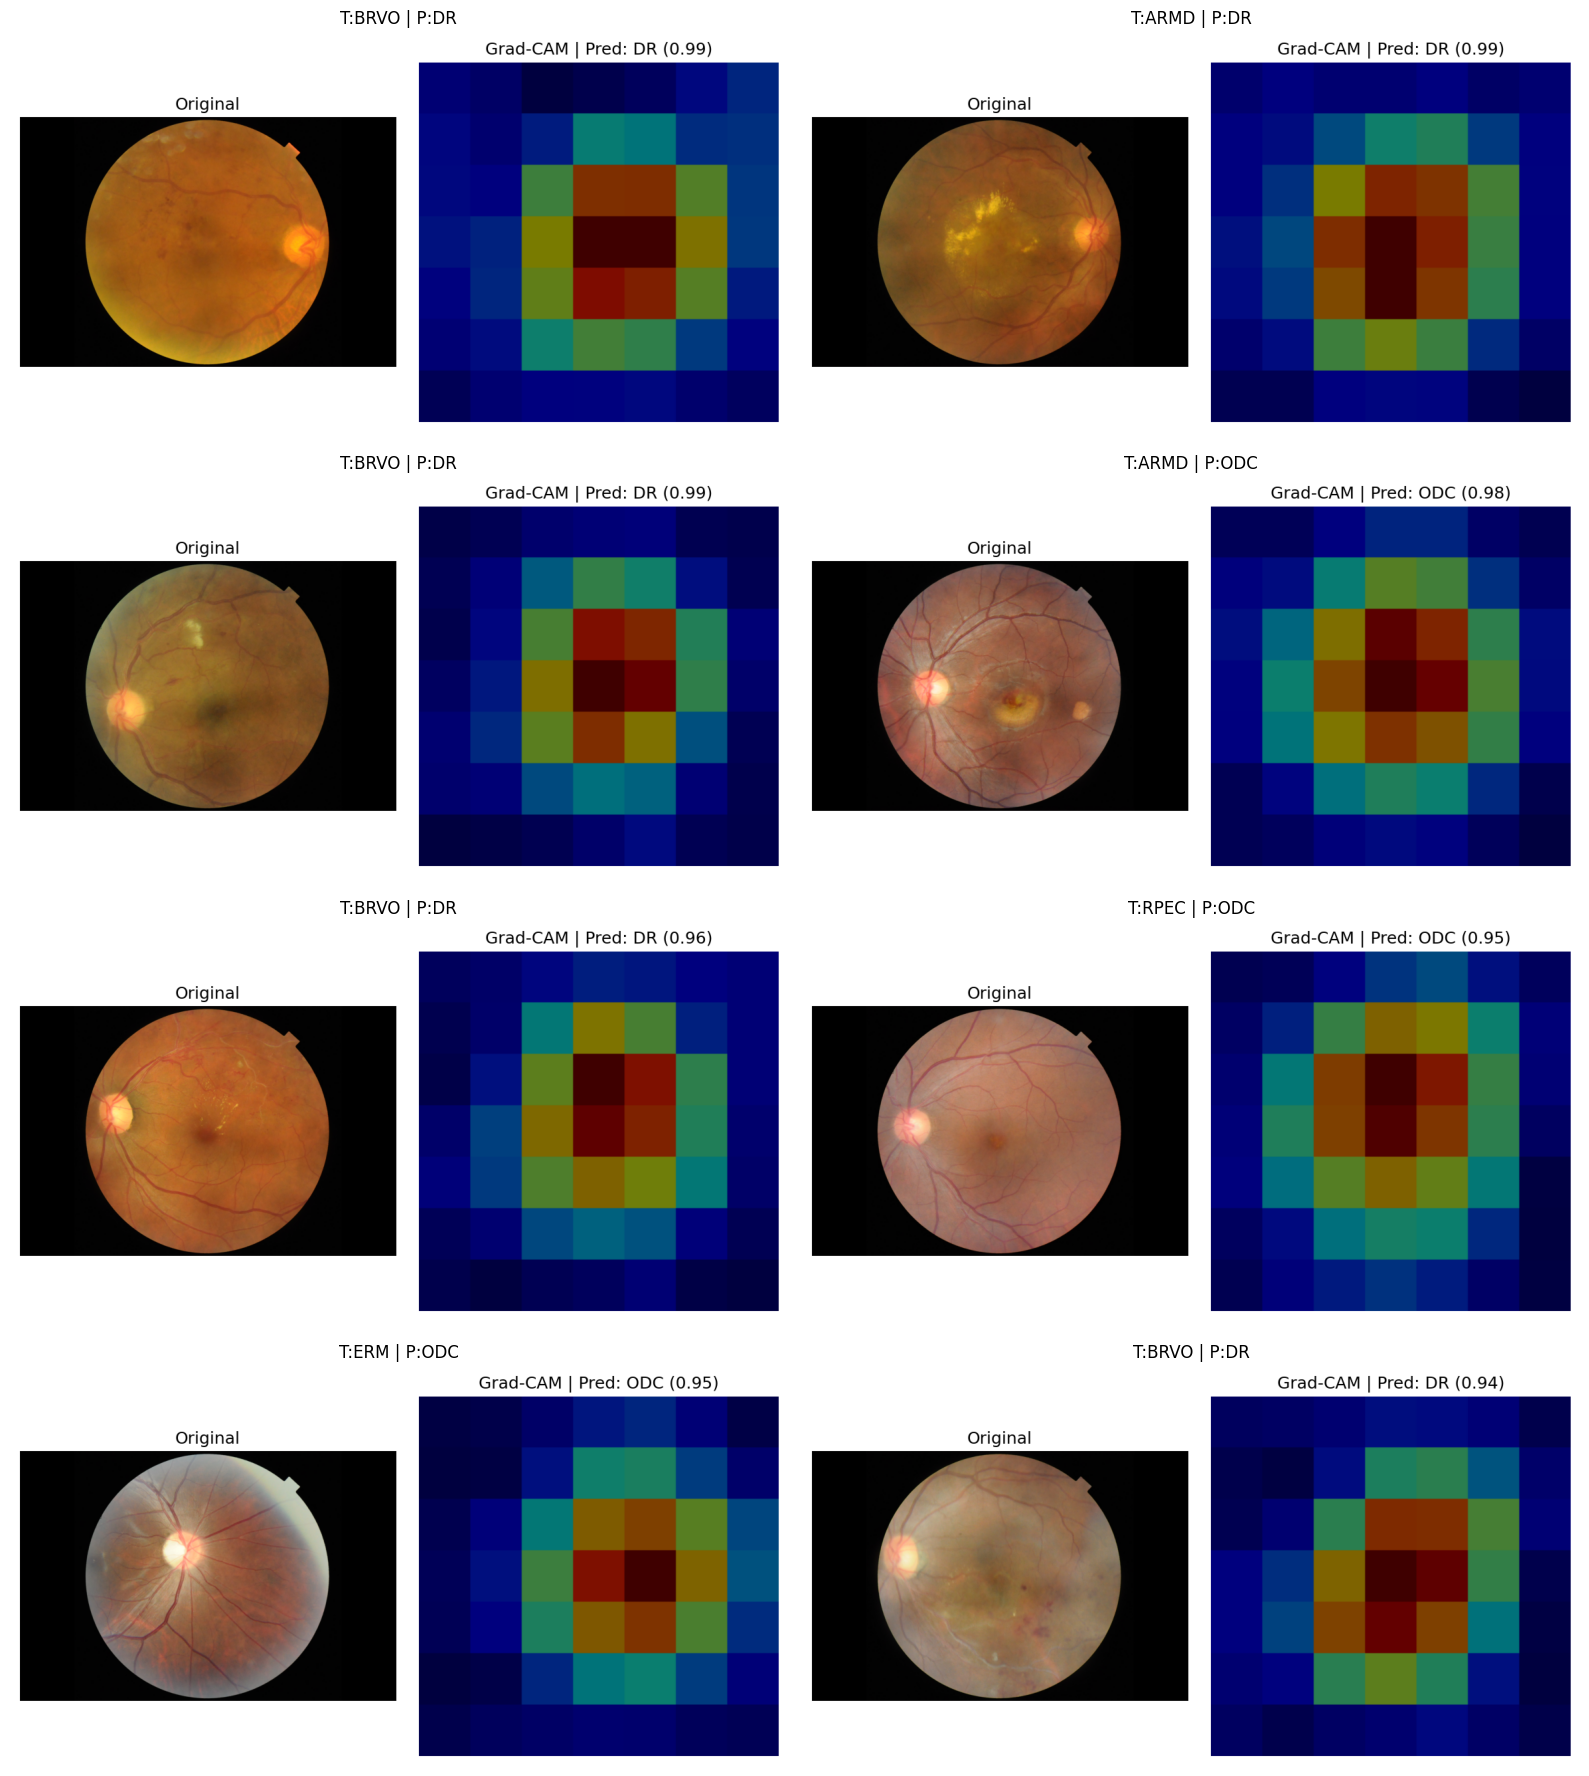

In [22]:
# ==== Grad-CAM for ResNet34 (Captum) ====

# 0) Imports / setup
import os, json, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
from torchvision import transforms

# Try Captum, auto-install if missing (not harmful if already installed)
try:
    from captum.attr import LayerGradCam, LayerAttribution
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "captum"])
    from captum.attr import LayerGradCam, LayerAttribution

# 1) Paths & constants
REPORT_DIR = Path(r"C:\datasets\eye_project\reports\resnet34_gradcam")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_DIR = Path(r"C:\datasets\eye_project\models")
CKPT_PATH = MODEL_DIR / "resnet34_best.pth"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = len(CLASSES)

# 2) (Re)build model & load weights if needed
try:
    _ = model
    _ = model.state_dict()
except NameError:
    import timm
    model = timm.create_model("resnet34", pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)
    state = torch.load(CKPT_PATH, map_location=DEVICE)
    model.load_state_dict(state)
model.eval()

# 3) Preprocessing must match training
preproc = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# 4) Grad-CAM set up: last conv of last block
#    ResNet34 -> layer4[-1].conv2 is a good target layer
target_layer = model.layer4[-1].conv2
gradcam = LayerGradCam(model, target_layer)

def gradcam_for_image(img_path, target="pred", alpha=0.5):
    """
    img_path: str or Path
    target: "pred" to explain predicted class,
            class index (int) to explain a specific class (e.g., true label)
    alpha: overlay strength
    returns: (fig, pred_idx, probs) and saves a PNG next to REPORT_DIR
    """
    # Load & preprocess
    pil = Image.open(img_path).convert("RGB")
    x = preproc(pil).unsqueeze(0).to(DEVICE)

    # Forward / probs
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)[0].detach().cpu().numpy()
        pred_idx = int(np.argmax(probs))

    # Decide which class to attribute
    target_idx = pred_idx if target == "pred" else int(target)

    # Grad-CAM attribution (batch, channel=1, h, w) at conv layer
    attr = gradcam.attribute(x, target=target_idx)
    # Upsample to input size
    heat = LayerAttribution.interpolate(attr, x.shape[-2:]).squeeze().detach().cpu().numpy()
    # Normalize to [0,1]
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(pil); ax[0].set_title("Original"); ax[0].axis("off")

    ax[1].imshow(pil)
    ax[1].imshow(heat, cmap="jet", alpha=alpha)
    ttl = f"Grad-CAM | Pred: {CLASSES[pred_idx]} ({probs[pred_idx]:.2f})"
    if isinstance(target, int):
        ttl += f" | Target: {CLASSES[target]}"
    ax[1].set_title(ttl)
    ax[1].axis("off")
    plt.tight_layout()

    # Save
    out_name = f"{Path(img_path).stem}_pred-{CLASSES[pred_idx]}_t-{('pred' if target=='pred' else CLASSES[target])}.png"
    out_path = REPORT_DIR / out_name
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    print("Saved:", out_path)
    return fig, pred_idx, probs

# 5) Build/refresh predictions (if not already available)
#    We'll reuse pred_df from earlier if it exists; else compute quickly from test_dl.
try:
    _ = pred_df
except NameError:
    # quick prediction pass over test set
    y_true, y_pred, y_prob, paths = [], [], [], []
    with torch.no_grad():
        for xb, yb in test_dl:
            if xb.nelement() == 0: continue
            paths.extend([p for p in test_df["img_path"].iloc[len(y_true):len(y_true)+len(yb)].tolist()])
            xb = xb.to(DEVICE)
            logits = model(xb)
            probs = F.softmax(logits, dim=1).cpu().numpy()
            y_prob.append(probs)
            y_pred.append(probs.argmax(1))
            y_true.append(yb.numpy())
    import pandas as pd
    y_prob = np.concatenate(y_prob, 0); y_pred = np.concatenate(y_pred, 0); y_true = np.concatenate(y_true, 0)
    pred_df = pd.DataFrame({
        "img_path": test_df["img_path"].values,  # align with test_df ordering
        "true_idx": y_true,
        "pred_idx": y_pred,
        "true_label": [CLASSES[i] for i in y_true],
        "pred_label": [CLASSES[i] for i in y_pred],
        "correct": (y_true == y_pred).astype(int),
    })

# 6) Pick N hard misclassifications (highest wrong confidence) and plot Grad-CAMs
N = 8
# Compute confidence for predicted class
def conf_for_row(row):
    # recompute prob for that image quickly
    pil = Image.open(row["img_path"]).convert("RGB")
    x = preproc(pil).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pr = F.softmax(model(x), dim=1)[0].cpu().numpy()
    return float(pr[row["pred_idx"]])

mis = pred_df[pred_df["correct"] == 0].copy()
if len(mis) > 0:
    # rank by model confidence in the wrong prediction (descending)
    mis["wrong_conf"] = mis.apply(conf_for_row, axis=1)
    sel = mis.sort_values("wrong_conf", ascending=False).head(N)
    print(f"Showing Grad-CAM for {len(sel)} most confident misclassifications...")

    cols = 2
    rows = math.ceil(len(sel) / cols)
    plt.figure(figsize=(cols*8, rows*4.5))
    for i, (_, r) in enumerate(sel.iterrows(), start=1):
        plt.subplot(rows, cols, i)
        # generate heatmap (target="pred" explains the wrong decision)
        fig, pred_idx, probs = gradcam_for_image(r["img_path"], target="pred", alpha=0.5)
        plt.close(fig)  # already saved by gradcam_for_image; avoid nested display
        # Also display inline for the grid
        img_show = Image.open(REPORT_DIR / f"{Path(r['img_path']).stem}_pred-{CLASSES[pred_idx]}_t-pred.png")
        plt.imshow(img_show); plt.axis("off")
        plt.title(f"T:{r['true_label']} | P:{r['pred_label']}")
    plt.tight_layout()
    plt.show()
else:
    print("No misclassifications in test set — showing 4 correct predictions instead.")
    corr = pred_df[pred_df["correct"] == 1].sample(4, random_state=0)
    for _, r in corr.iterrows():
        gradcam_for_image(r["img_path"], target="pred", alpha=0.5)
